In [2]:
from google.colab import drive
import os
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
os.chdir("drive/MyDrive")
print(os.getcwd())
print(os.listdir())
print("VAINF" in os.listdir())

/content/drive/MyDrive
['Classroom', '2021529_DivyajeetSingh_ThinkingAboutDesign-I.gdoc', '2021529_DivyajeetSingh_ThinkingAboutDesign-II.gdoc', 'Clubs Information | MTech Induction.gsheet', 'Tut 1.pdf', 'ECE111_Sec-A_DivyjaeetSingh_2021529.pdf', 'A1_Resources_2021529.gdoc', 'skn-hmfm-qyr - Feb 8, 2022.gjam', 'Scenario 1.gdoc', 'LAB 1-4 (4).pdf', 'LAB 1-4 (3).pdf', 'TUTORIAL 1-4 (1).pdf', 'TUT 1-4 (1).pdf', 'LAB 1-4 (2).pdf', 'LAB 1-4 (1).pdf', 'LAB 1-4.pdf', 'TUT 1-4.pdf', 'DivyajeetSingh_2021529_TUT 1-4.pdf', 'DivyajeetSingh_2021529_LAB 1-4.pdf', 'DivyajeetSingh_2021529_MahakSharma_E1.gdoc', 'DivyajeetSingh_2021529 (3).pdf', 'LAB 1-4.gdoc', 'DivyajeetSingh_2021529 (2).pdf', 'A2_Resources_2021529.gdoc', 'DivyajeetSingh_Interviews.gdoc', 'DivyajeetSingh_2021529 (1).pdf', 'DivyajeetSingh-2021529-MahakSharma-E1.docx', 'DivyajeetSingh_2021529_Tut5 (1).pdf', 'DivyajeetSingh_2021529_Tut6 (4).pdf', 'DivyajeetSingh_2021529_Tut8 (5).pdf', 'DivyajeetSingh_2021529_Tut8 (1) (2).pdf', 'DivyajeetSin

In [ ]:
! git clone https://github.com/VainF/DeepLabV3Plus-Pytorch/

Cloning into 'DeepLabV3Plus-Pytorch'...
remote: Enumerating objects: 705, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 705 (delta 25), reused 30 (delta 14), pack-reused 653
Receiving objects: 100% (705/705), 8.26 MiB | 18.08 MiB/s, done.
Resolving deltas: 100% (380/380), done.


In [4]:
import os
import torch
import itertools
import numpy as np
from PIL import Image
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from VAINF.network import modeling
from torchvision.models import segmentation
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

In [5]:
class IDD(Dataset):
    root: str
    sample: float|None
    transform: transforms.Compose|None
    target_transform: transforms.Compose|None
    images: list[str]
    masks: list[str]

    CATEGORY_TO_LABEL: dict[str, int] = {
        "Road": 0, "Sidewalk": 2, "Person": 4, "Rider": 5, "Motorbike": 6,
        "Bicycle": 7, "Car": 9, "Truck": 10, "Bus": 11, "Train": 12,
        "Wall": 14, "Fence": 15, "Traffic Sign": 18, "Traffic Light": 19,
        "Pole": 20, "Building": 22, "Vegetation": 24, "Sky": 25, "Unlabeled": 255
    }

    LABEL_TO_CATEGORY: dict[int, str] = {mask: label for label, mask in CATEGORY_TO_LABEL.items()}

    LABEL_TO_COLOR: dict[int, tuple[int]] = {
        0: (128, 64, 128),  2: (244, 35, 232),  4: (220, 20, 60), 5: (255, 0, 0),
        6: (0, 0, 230),  7: (119, 11, 32), 9: (0, 0, 142), 10: (0, 0, 70),
        11: (0, 60, 100), 12: (0, 80,100), 14: (102, 102, 156), 15: (190, 153, 153),
        18: (220, 220, 0), 19: (250, 170, 30), 20: (153, 153, 153), 22: (70, 70, 70),
        24: (107, 142, 35), 25: (70, 130, 180),  255: (0, 0, 0)
    }

    CITYSCAPES_LABEL_TO_IDD_LABEL: dict[int, int] = {
        0: 0, 1: 2, 2: 22, 3: 14, 4: 15, 5: 20, 6: 19, 7: 18, 8: 24, 9: 255,
        10: 25, 11: 4, 12: 5, 13: 9, 14: 10, 15: 11, 16: 12, 17: 6, 18: 7,
        255: 255
    }

    CITYSCAPES_COLOR_TO_CITYSCAPES_LABEL: dict[tuple[int], int] = {
        (0, 0, 0): 255, (111, 74, 0): 255, (81, 0, 81): 255, (128, 64, 128): 0, (244, 35,232): 1,
        (250, 170, 160): 255, (230, 150, 140): 255, (70, 70, 70): 2, (102, 102, 156): 3,
        (190, 153, 153): 4, (180, 165, 180): 255, (150, 100, 100): 255, (150, 120, 90): 255,
        (153, 153, 153): 5, (250, 170, 30): 6, (220, 220, 0): 7, (107, 142, 35): 8,
        (152, 251, 152): 9, (70, 130, 180): 10, (220, 20, 60): 11, (255, 0, 0): 12,
        (0, 0, 142): 13, (0, 0, 70): 14, (0, 60, 100): 15, (0, 0, 90): 255, (0, 0, 110): 255,
        (0, 80, 100): 16, (0, 0, 230): 17, (119, 11, 32): 18, (0, 0, 142): 13
    }

    def __init__(self, root, sample=1.0, shuffle=False, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        images = os.path.join(root, "image_archive")
        masks = os.path.join(root, "mask_archive")
        self.images = [os.path.join(images, image) for image in sorted(os.listdir(images), key=lambda f: int(f.split("_")[-1][:-4]))]
        self.masks = [os.path.join(masks, mask) for mask in sorted(os.listdir(masks), key=lambda f: int(f.split("_")[-1][:-4]))]
        size = int(sample * len(self.images))
        if shuffle:
            indices = torch.randperm(len(self.images))[:size]
        else:
            indices = torch.arange(len(self.images))[:size]
        self.images = [self.images[i] for i in indices]
        self.masks = [self.masks[i] for i in indices]

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> tuple[torch.Tensor]:
        image = Image.open(self.images[index])
        mask = Image.open(self.masks[index])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        return image, mask

    @staticmethod
    def convert_to_IDD(mask: torch.Tensor, from_: str = "gray") -> torch.Tensor|None:
        if from_ == "gray":
            mask.map_(mask, lambda index, value: IDD.CITYSCAPES_LABEL_TO_IDD_LABEL.get(value, 255))
            return
        gray_mask = torch.zeros(512, 512)
        mask = (mask*255).to(torch.uint8)
        for i, j in itertools.product(range(512), range(512)):
            color = mask[0, i, j].item(), mask[1, i, j].item(), mask[2, i, j].item()
            gray_mask[i, j] = IDD.CITYSCAPES_COLOR_TO_CITYSCAPES_LABEL.get(color, 255)
        return gray_mask

    @staticmethod
    def color_mask(mask: torch.Tensor, scheme: str = "idd", highlight: str|None = None) -> torch.Tensor:
        if scheme == "cityscapes":
            IDD.convert_to_IDD(mask)
        colored_mask = torch.zeros(*mask.shape, 3, dtype=torch.uint8)
        for label, color in IDD.LABEL_TO_COLOR.items():
            if highlight is not None:
                color = color if IDD.CATEGORY_TO_LABEL.get(highlight) == label else (100, 100, 100)
            colored_mask[mask == label] = torch.tensor(color, dtype=torch.uint8)
        return colored_mask

In [6]:
class PILToTensor:
    def __call__(self, image):
        image = torch.as_tensor(np.array(image), dtype=torch.uint8)
        return image

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

target_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    PILToTensor()
])

# root = r"IDD20K_II"
# dataset = IDD(root=root, sample=0.3, shuffle=True, transform=transform, target_transform=target_transform)
# dataloader = DataLoader(dataset, batch_size=8)
# NUM_BATCHES: int = len(dataloader)
NUM_BATCHES = 262

In [147]:
# device = torch.device("cuda:0")
device = torch.device("cpu")
deeplab_model = modeling.__dict__["deeplabv3plus_resnet101"](num_classes=19, output_stride=8)
deeplab_model.load_state_dict(torch.load("DeepLabV3Plus-Resnet101.pth.tar", map_location=device)["model_state"])
# deeplab_model.to(device)
deeplab_model.eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 226MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
for batch, (images, masks) in tqdm(enumerate(dataloader)):
    with torch.no_grad():
        images = images.to(device)
        outputs = deeplab_model(images)
        predictions = outputs.max(1)[1].detach().reshape(-1, 512, 512)
        torch.save(images, f"cv-segmentation-outputs/Images/Batch-{batch}.torch")
        torch.save(masks, f"cv-segmentation-outputs/Masks/Batch-{batch}.torch")
        torch.save(predictions, f"cv-segmentation-outputs/Predictions/Batch-{batch}.torch")
    del images
    del outputs
    torch.cuda.empty_cache()

  0%|          | 0/262 [00:00<?, ?it/s]

In [ ]:
next(deeplab_model.parameters()).device

device(type='cuda', index=0)

In [7]:
class Metrics:
    def __init__(self, root: str, num_batches: int, device: str = "cpu"):
        self.root = root
        self.num_batches = num_batches
        self.device = torch.device(device)

    def pixelwise_accuracy(self, category_label: int|None = None) -> float:
        correct = total = 0
        iterator = range(self.num_batches)
        iterator = tqdm(iterator) if category_label is None else iterator
        for batch in iterator:
            masks = torch.load(f"{self.root}/Masks/Batch-{batch}.torch", map_location=self.device)
            predictions = torch.load(f"{self.root}/Predictions/Batch-{batch}.torch", map_location=self.device)
            if category_label is None:
                correct = torch.sum(masks == predictions)
                total = masks.flatten().shape[0]
            else:
                correct = torch.sum((masks == category_label) & (predictions == category_label))
                total = torch.sum(masks == category_label)
        return (correct / total).item()

    def dice_coefficient(self, category_label: int) -> float:
        total_original = total_predicted = intersection = 0
        for batch in range(self.num_batches):
            masks = torch.load(f"{self.root}/Masks/Batch-{batch}.torch", map_location=self.device)
            predictions = torch.load(f"{self.root}/Predictions/Batch-{batch}.torch", map_location=self.device)
            intersection += torch.sum((masks == category_label) & (predictions == category_label)).float()
            total_original += torch.sum(masks == category_label).float()
            total_predicted += torch.sum(predictions == category_label).float()
        return ((2.0 * intersection) / (total_original + total_predicted + 1e-12)).item()

    def IoU(self, category_label: int) -> float:
        intersection = union = 0
        for batch in range(self.num_batches):
            masks = torch.load(f"{self.root}/Masks/Batch-{batch}.torch", map_location=self.device)
            predictions = torch.load(f"{self.root}/Predictions/Batch-{batch}.torch", map_location=self.device)
            intersection += torch.sum((masks == category_label) & (predictions == category_label)).float()
            union += torch.sum((masks == category_label) | (predictions == category_label)).float()
        return (intersection / union).item()

    def IoU_per_sample(self, mask: torch.Tensor, predicted: torch.Tensor, category_label: int) -> float:
        intersection = torch.sum((mask == category_label) & (predicted == category_label)).float()
        union = torch.sum((mask == category_label) | (predicted == category_label)).float()
        return (intersection / union).item()

    def precision_recall_F1(self, category_label: int) -> tuple[float]:
        TP = FP = FN = 0
        for batch in range(self.num_batches):
            masks = torch.load(f"{self.root}/Masks/Batch-{batch}.torch", map_location=self.device)
            predictions = torch.load(f"{self.root}/Predictions/Batch-{batch}.torch", map_location=self.device)
            TP += torch.sum((masks == category_label) & (predictions == category_label))
            FP += torch.sum((masks != category_label) & (predictions == category_label))
            FN += torch.sum((masks == category_label) & (predictions != category_label))
        precision, recall = (TP / (TP + FP)).item(), (TP / (TP + FN)).item()
        return precision, recall, (2*precision*recall)/(precision+recall)

    def confusion_matrix(self) -> tuple[torch.Tensor, list[str]]:
        keys = sorted(IDD.LABEL_TO_COLOR.keys())
        matrix = torch.zeros(19, 19)
        pixels_per_class = torch.zeros(19)
        for batch in tqdm(range(self.num_batches)):
            masks = torch.load(f"{self.root}/Masks/Batch-{batch}.torch", map_location=self.device)
            predictions = torch.load(f"{self.root}/Predictions/Batch-{batch}.torch", map_location=self.device)
            for i, label_true in enumerate(keys):
                masks_true = masks == label_true
                pixels_per_class[i] += masks_true.sum()
                for j, label_pred in enumerate(keys):
                    matrix[i, j] += torch.sum(masks_true & predictions == label_pred)
        for i in range(19):
            matrix[i] /= (pixels_per_class[i] + 1e-8)
        return matrix, keys


In [96]:
metrics = Metrics(root="cv-segmentation-outputs", num_batches=NUM_BATCHES, device="cpu")

In [ ]:
print("Pixelwise Accuracy:", metrics.pixelwise_accuracy())
for label, category in IDD.LABEL_TO_CATEGORY.items():
    accuracy = metrics.pixelwise_accuracy(category_label=label)
    print(f"Pixelwise Accuracy for class {category}:", accuracy)

  0%|          | 0/262 [00:00<?, ?it/s]

Pixelwise Accuracy: 0.7160231471061707
Pixelwise Accuracy for class Road: 0.9836636185646057
Pixelwise Accuracy for class Sidewalk: 0.020291363820433617
Pixelwise Accuracy for class Person: 0.3142322599887848
Pixelwise Accuracy for class Rider: 0.2590262293815613
Pixelwise Accuracy for class Motorbike: 0.08950617164373398
Pixelwise Accuracy for class Bicycle: 0.0028037382289767265
Pixelwise Accuracy for class Car: 0.6851978898048401
Pixelwise Accuracy for class Truck: 0.0
Pixelwise Accuracy for class Bus: 0.0202464796602726
Pixelwise Accuracy for class Train: 0.0
Pixelwise Accuracy for class Wall: 0.0010045203380286694
Pixelwise Accuracy for class Fence: 0.7999590635299683
Pixelwise Accuracy for class Traffic Sign: 0.33252280950546265
Pixelwise Accuracy for class Traffic Light: 0.0
Pixelwise Accuracy for class Pole: 0.1974167674779892
Pixelwise Accuracy for class Building: 0.710085928440094
Pixelwise Accuracy for class Vegetation: 0.7507008910179138
Pixelwise Accuracy for class Sky: 0.

In [ ]:
for label, category in IDD.LABEL_TO_CATEGORY.items():
    dice_coeff = metrics.dice_coefficient(category_label=label)
    print(f"Dice Coefficient for class {category}:", dice_coeff)

Dice Coefficient for class Road: 0.8473682999610901
Dice Coefficient for class Sidewalk: 0.17147855460643768
Dice Coefficient for class Person: 0.39689794182777405
Dice Coefficient for class Rider: 0.31636640429496765
Dice Coefficient for class Motorbike: 0.31352004408836365
Dice Coefficient for class Bicycle: 0.05926137790083885
Dice Coefficient for class Car: 0.6218283772468567
Dice Coefficient for class Truck: 0.3380579948425293
Dice Coefficient for class Bus: 0.5637191534042358
Dice Coefficient for class Train: 0.0023486672434955835
Dice Coefficient for class Wall: 0.2748376429080963
Dice Coefficient for class Fence: 0.14509819447994232
Dice Coefficient for class Traffic Sign: 0.11948142945766449
Dice Coefficient for class Traffic Light: 0.0025520515628159046
Dice Coefficient for class Pole: 0.2409321367740631
Dice Coefficient for class Building: 0.5946892499923706
Dice Coefficient for class Vegetation: 0.8268332481384277
Dice Coefficient for class Sky: 0.9192619323730469
Dice Coef

In [ ]:
running_iou = 0
for label, category in IDD.LABEL_TO_CATEGORY.items():
    iou = metrics.IoU(category_label=label)
    running_iou += iou
    print(f"Intersection over Union for class {category}:", iou)
print("Mean Intersection over Union (mIoU):", running_iou/(len(IDD.LABEL_TO_CATEGORY)-1))

Intersection over Union for class Road: 0.7351597547531128
Intersection over Union for class Sidewalk: 0.09377989917993546
Intersection over Union for class Person: 0.24758119881153107
Intersection over Union for class Rider: 0.1879069209098816
Intersection over Union for class Motorbike: 0.18590202927589417
Intersection over Union for class Bicycle: 0.03053547628223896
Intersection over Union for class Car: 0.45119795203208923
Intersection over Union for class Truck: 0.20341143012046814
Intersection over Union for class Bus: 0.3924853205680847
Intersection over Union for class Train: 0.0011757143074646592
Intersection over Union for class Wall: 0.1593111753463745
Intersection over Union for class Fence: 0.07822419703006744
Intersection over Union for class Traffic Sign: 0.06353642791509628
Intersection over Union for class Traffic Light: 0.0012776560615748167
Intersection over Union for class Pole: 0.1369657963514328
Intersection over Union for class Building: 0.4231727719306946
Inter

In [16]:
for label, category in IDD.LABEL_TO_CATEGORY.items():
    precision, recall, f1_score = metrics.precision_recall_F1(category_label=label)
    print(f"[Class {category}]: {precision = }, {recall = }, {f1_score = }")

[Class Road]: precision = 0.7482602596282959, recall = 0.976739227771759, f1_score = 0.8473685395271549
[Class Sidewalk]: precision = 0.1029103472828865, recall = 0.5138562321662903, f1_score = 0.171478562774707
[Class Person]: precision = 0.3279789388179779, recall = 0.5024866461753845, f1_score = 0.3968979328243315
[Class Rider]: precision = 0.5766028165817261, recall = 0.21798422932624817, f1_score = 0.31636639748206646
[Class Motorbike]: precision = 0.5809447765350342, recall = 0.214691624045372, f1_score = 0.31352003871114426
[Class Bicycle]: precision = 0.0346524603664875, recall = 0.20446501672267914, f1_score = 0.059261380427443826
[Class Car]: precision = 0.4855184853076935, recall = 0.8645526766777039, f1_score = 0.6218284159658408
[Class Truck]: precision = 0.7103180289268494, recall = 0.22181189060211182, f1_score = 0.3380579930416765
[Class Bus]: precision = 0.7143606543540955, recall = 0.46554654836654663, f1_score = 0.5637191402113282
[Class Train]: precision = 0.0095783

In [97]:
confusion_matrix, keys = metrics.confusion_matrix()

  0%|          | 0/262 [00:00<?, ?it/s]

<Axes: >

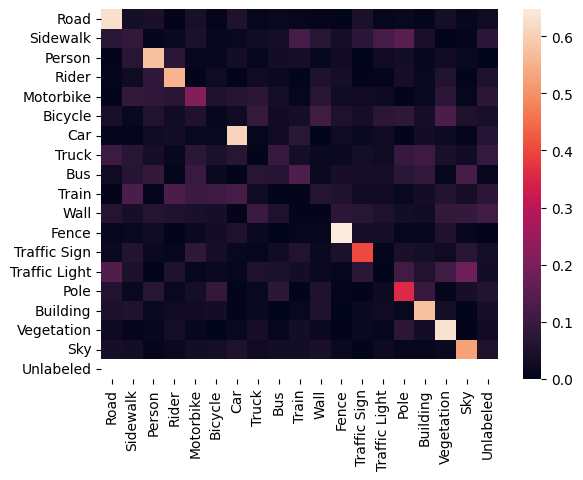

In [19]:
labels = IDD.CATEGORY_TO_LABEL.keys()
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels)

In [ ]:
bad_ious = {label: [] for label, _ in IDD.LABEL_TO_CATEGORY.items()}

device = torch.device("cpu")
for label, category in IDD.LABEL_TO_CATEGORY.items():
    for batch in torch.randperm(NUM_BATCHES):
        masks = torch.load(f"cv-segmentation-outputs/Masks/Batch-{batch}.torch", map_location=device)
        preds = torch.load(f"cv-segmentation-outputs/Predictions/Batch-{batch}.torch", map_location=device)

        iou = metrics.IoU_per_sample(masks[0], preds[0], category_label=label)
        if iou < 0.5 and len(bad_ious[label]) < 3:
            bad_ious[label].append((batch, 0, iou))

        iou = metrics.IoU_per_sample(masks[1], preds[1], category_label=label)
        if iou < 0.5 and len(bad_ious[label]) < 3:
            bad_ious[label].append((batch, 1, iou))

        if len(bad_ious[label]) >= 3:
            break
    print("Found bad IoUs for", category)

Found bad IoUs for Road
Found bad IoUs for Sidewalk
Found bad IoUs for Person
Found bad IoUs for Rider
Found bad IoUs for Motorbike
Found bad IoUs for Bicycle
Found bad IoUs for Car
Found bad IoUs for Truck
Found bad IoUs for Bus
Found bad IoUs for Train
Found bad IoUs for Wall
Found bad IoUs for Fence
Found bad IoUs for Traffic Sign
Found bad IoUs for Traffic Light
Found bad IoUs for Pole
Found bad IoUs for Building
Found bad IoUs for Vegetation
Found bad IoUs for Sky
Found bad IoUs for Unlabeled


Done category: Road
Done category: Sidewalk
Done category: Person
Done category: Rider
Done category: Motorbike
Done category: Bicycle
Done category: Car
Done category: Truck
Done category: Bus
Done category: Train
Done category: Wall
Done category: Fence
Done category: Traffic Sign
Done category: Traffic Light
Done category: Pole
Done category: Building
Done category: Vegetation
Done category: Sky


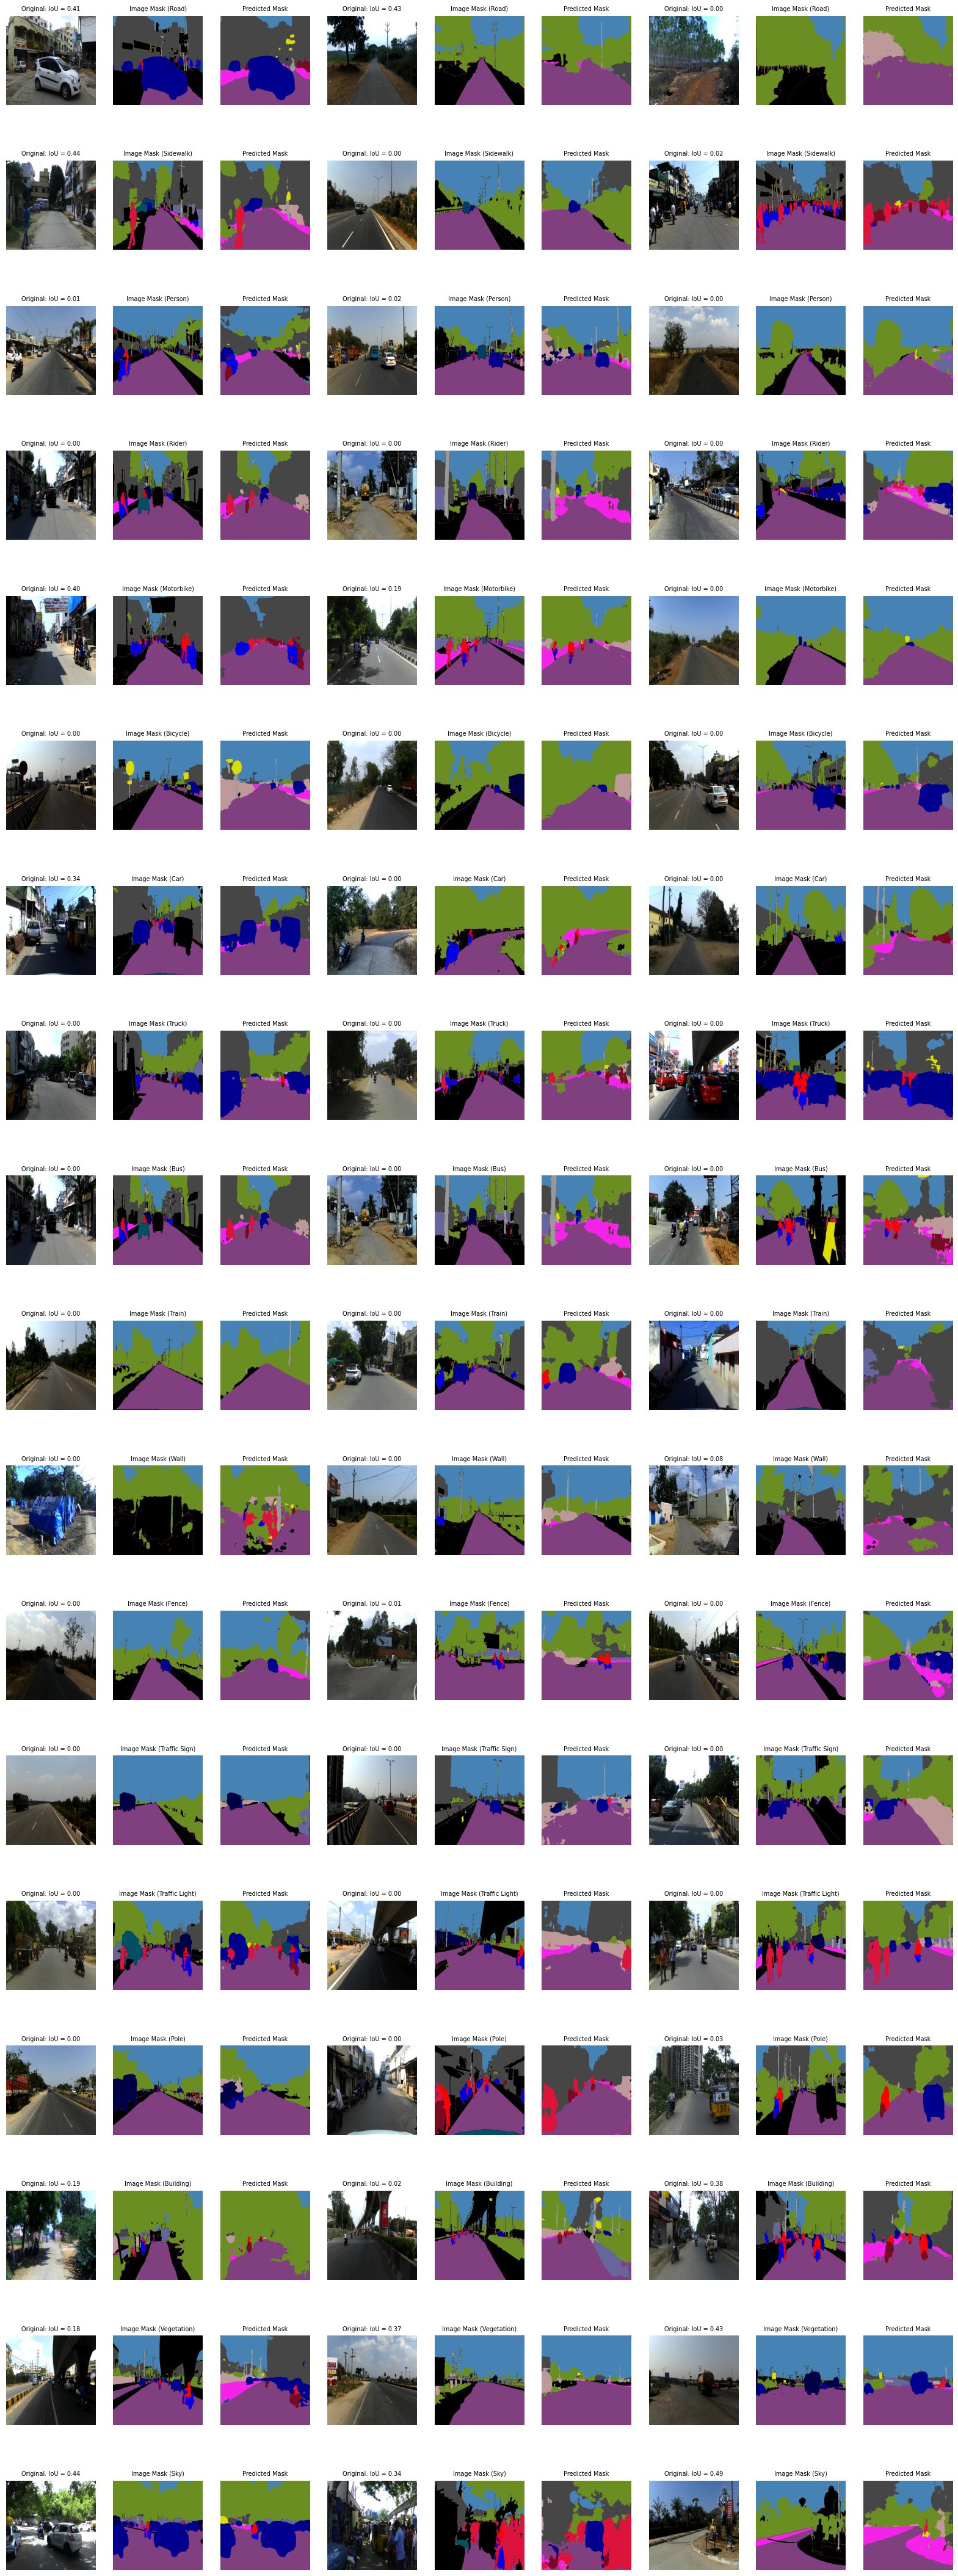

In [ ]:
fig, axes = plt.subplots(18, 9, figsize=(20, 55))

for i, (label, examples) in enumerate(bad_ious.items()):
    if label == 255: continue
    category = IDD.LABEL_TO_CATEGORY[label]
    j = 0
    for batch, index, iou in examples:
        image = torch.load(f"cv-segmentation-outputs/Images/Batch-{batch}.torch", map_location=device)[index]
        mask = torch.load(f"cv-segmentation-outputs/Masks/Batch-{batch}.torch", map_location=device)[index]
        pred = torch.load(f"cv-segmentation-outputs/Predictions/Batch-{batch}.torch", map_location=device)[index]
        axes[i, j].set_title(f"Original: IoU = {iou:.2f}", fontsize=7)
        axes[i, j].imshow(image.permute(1, 2, 0))
        axes[i, j].axis("off")
        j += 1
        axes[i, j].set_title(f"Image Mask ({category})", fontsize=7)
        axes[i, j].imshow(IDD.color_mask(mask))
        axes[i, j].axis("off")
        j += 1
        axes[i, j].set_title(f"Predicted Mask", fontsize=7)
        axes[i, j].imshow(IDD.color_mask(pred))
        axes[i, j].axis("off")
        j += 1
    print("Done category:", category)

In [18]:
os.listdir("Cityscapes Dataset")

['train', 'val']

In [156]:
T = transforms.Compose([transforms.Resize((512, 512*2)), transforms.ToTensor()])

for image_path in tqdm(os.listdir("Cityscapes Dataset/val/")):
    image_and_mask = T(Image.open(f"Cityscapes Dataset/val/{image_path}"))
    image, mask = image[:, :, :512], image[:, :, 512:]
    output = deeplab_model(image.unsqueeze(0))
    prediction = output.max(1)[1].detach().reshape(-1, 512, 512)
    torch.save(prediction, f"Cityscapes Dataset/Inferences/{image_path.rstrip('.jpg')}.torch")

  0%|          | 0/565 [00:00<?, ?it/s]